In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
sys.path.append('../')
from scipy.signal import butter, iirnotch, firwin, filtfilt, periodogram
from utils.signal_processing import *
import pyemgpipeline as pep

In [2]:
from process_data import *

In [3]:
'''
def data_from_files(data, metadata):
    sess_data = pd.read_csv(data,header=None)
    sess_metadata = pd.read_csv(metadata, names=['start_time','category'])
    category_instances = {}
    for i, row in sess_metadata.iterrows():
        start_time = row['start_time']
        category = row['category'].strip()
        end_time = sess_metadata.iloc[i + 1]['start_time'] if i < (len(sess_metadata) - 1) else sess_data.iloc[-1][0]

        channels = sess_data.loc[(sess_data[0] >= start_time) & (sess_data[0] < end_time)].iloc[:,[2,3,6,7]]
        instances = pd.DataFrame()
        instances['e1'] = tripolar_laplacian(channels[3],channels[2])
        instances['e2'] = tripolar_laplacian(channels[7],channels[6])

        if category not in category_instances:
            category_instances[category] = []
        category_instances[category].append(instances)
    return category_instances
'''

"\ndef data_from_files(data, metadata):\n    sess_data = pd.read_csv(data,header=None)\n    sess_metadata = pd.read_csv(metadata, names=['start_time','category'])\n    category_instances = {}\n    for i, row in sess_metadata.iterrows():\n        start_time = row['start_time']\n        category = row['category'].strip()\n        end_time = sess_metadata.iloc[i + 1]['start_time'] if i < (len(sess_metadata) - 1) else sess_data.iloc[-1][0]\n\n        channels = sess_data.loc[(sess_data[0] >= start_time) & (sess_data[0] < end_time)].iloc[:,[2,3,6,7]]\n        instances = pd.DataFrame()\n        instances['e1'] = tripolar_laplacian(channels[3],channels[2])\n        instances['e2'] = tripolar_laplacian(channels[7],channels[6])\n\n        if category not in category_instances:\n            category_instances[category] = []\n        category_instances[category].append(instances)\n    return category_instances\n"

In [4]:
'''
def process_signal(signal):
    signal = np.array(signal)
    #signal = np.array(signal - signal.mean())
    emg = pep.wrappers.EMGMeasurement(signal, hz=250)
    emg.apply_dc_offset_remover()
    emg.apply_bandpass_filter(2,5,124)
    #emg.apply_full_wave_rectifier()
    #emg.apply_end_frame_cutter(n_end_frames=50)
    return emg
'''

'\ndef process_signal(signal):\n    signal = np.array(signal)\n    #signal = np.array(signal - signal.mean())\n    emg = pep.wrappers.EMGMeasurement(signal, hz=250)\n    emg.apply_dc_offset_remover()\n    emg.apply_bandpass_filter(2,5,124)\n    #emg.apply_full_wave_rectifier()\n    #emg.apply_end_frame_cutter(n_end_frames=50)\n    return emg\n'

In [5]:
'''
def plot_emg(cat_dict, category, instance, electrode, plot=True):
    signal = cat_dict[category][instance][electrode]
    emg = process_signal(signal)
    if plot:
        emg.plot()
        #plt.plot(signal)
        #plt.title(f'{category}: {instance}, electrode {electrode}')
    return emg #signal #
'''

"\ndef plot_emg(cat_dict, category, instance, electrode, plot=True):\n    signal = cat_dict[category][instance][electrode]\n    emg = process_signal(signal)\n    if plot:\n        emg.plot()\n        #plt.plot(signal)\n        #plt.title(f'{category}: {instance}, electrode {electrode}')\n    return emg #signal #\n"

In [6]:
sess3_data = 'test_sess3_data.txt'
sess3_metadata = 'test_sess3_metadata.txt'
cat_instances3 = data_from_files(sess3_data, sess3_metadata)

In [7]:
sess3_md_df = pd.read_csv(sess3_metadata,header=None)
sess3_md_df

,0,1
0,2.601756e+06,REST
1,2.601760e+06,CLENCH FIST
2,2.601761e+06,HOLD
3,2.601765e+06,STOP
4,2.601766e+06,REST
5,2.601770e+06,CLENCH FIST
6,2.601771e+06,HOLD
7,2.601775e+06,STOP
8,2.601776e+06,REST
9,2.601780e+06,CLENCH FIST


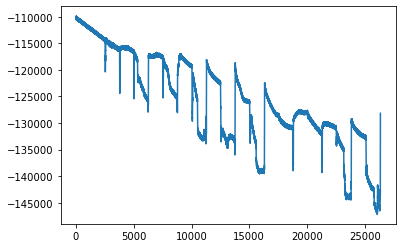

In [8]:
sess0_data = 'test_sess0_data.txt'
sess_0_df = pd.read_csv(sess0_data,header=None)
plt.plot(sess_0_df[2])

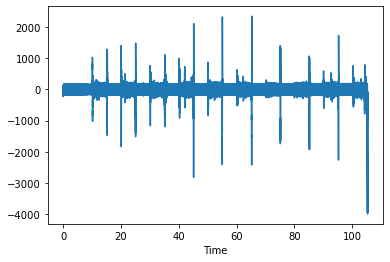

In [9]:
lap = tripolar_laplacian(sess_0_df[3],sess_0_df[2])
emg = process_signal(lap)
emg.plot()

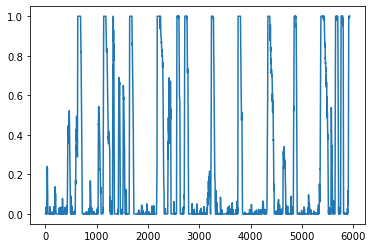

In [10]:
sess_3_df = pd.read_csv(sess3_data,header=None)
plt.plot(sess_3_df[8])

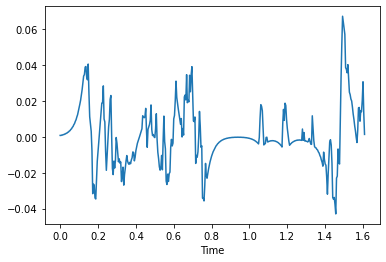

In [11]:
plot_emg(cat_instances3, 'HOLD', 0, 'e1')

In [12]:
sess0_data = 'test_sess0_data.txt'
sess0_metadata = 'test_sess0_metadata.txt'
cat_instances0 = data_from_files(sess0_data, sess0_metadata)

In [13]:
sess1_data = 'test_sess1_data.txt'
sess1_metadata = 'test_sess1_metadata.txt'
cat_instances1 = data_from_files(sess1_data, sess1_metadata)

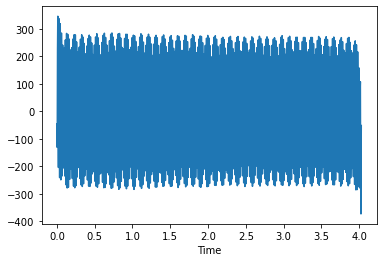

In [14]:
for i in range(1):
    plot_emg(cat_instances0, 'REST', i, 'e2')

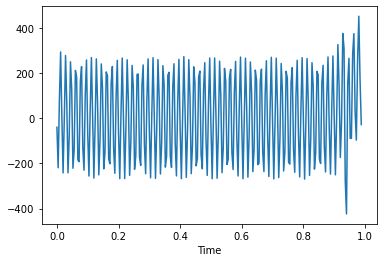

In [15]:
for i in range(1):
    emg_clench02 = plot_emg(cat_instances0, 'CLENCH', i, 'e2')

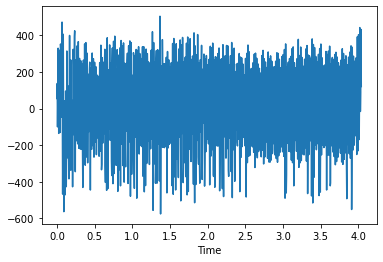

In [16]:
for i in range(1):
    emg_holdclench02 = plot_emg(cat_instances0, 'HOLD CLENCH', i, 'e2')

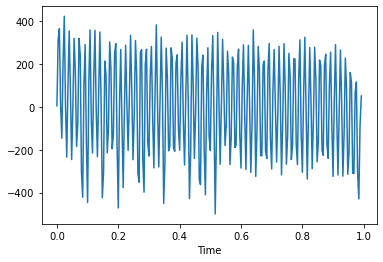

In [17]:
for i in range(1):
    emg_unclench02 = plot_emg(cat_instances0, 'STOP CLENCH', i, 'e2')

In [18]:
from utils.features import *

In [19]:
from sklearn.decomposition import PCA

In [73]:
# must divide by time (number of seconds for some features)
def collect_feats(cat_instances,cat,num=10):
    feats = []
    for i in range(num):
        instance_feats = []
        emg_data = plot_emg(cat_instances, cat, i, 'e2', plot=False).data
        #instance_feats.append(root_mean_square(emg_data))
        #instance_feats.append(waveform_length(emg_data)/emg_data.shape[0])
        #instance_feats.append(zero_crossings(emg_data)/emg_data.shape[0])
        #wcs = calculate_wavelet_coefficients(emg_data)
        #pca = PCA(n_components=2, svd_solver='full')
        #feat = pca.fit_transform(wcs)
        #instance_feats.append(feat)
        power, freqs = to_fdomain(data=emg_data, sampling_rate=250)
        #pf = peak_frequencies(power, freqs)
        #meanf = mean_frequency(power, freqs)
        #medianf = median_frequency(power, freqs)
        instance_feats = calculate_average_power(power, freqs, n=1)
        #instance_feats.append(meanf)
        feats.append(instance_feats)
    return feats

In [74]:
clench_feats = collect_feats(cat_instances0, cat='CLENCH')

In [75]:
clench_feats

[[9410413.772971075],
 [12512289.743029146],
 [14742308.613970738],
 [13569328.441265022],
 [13837452.632036056],
 [13255921.254192073],
 [12513416.703547414],
 [14064737.555509172],
 [20850464.41160092],
 [13535646.492037095]]

In [76]:
rest_feats = collect_feats(cat_instances0, cat='REST')

In [77]:
rest_feats

[[37962371.69822119],
 [48094702.83506059],
 [50278835.26170355],
 [53836619.587099254],
 [54548300.05845553],
 [49395898.87054998],
 [50951671.20467548],
 [48673154.44351271],
 [55087400.95335925],
 [53807502.26664482]]

In [78]:
hold_feats = collect_feats(cat_instances0, cat='HOLD CLENCH')

In [79]:
hold_feats

[[57581358.13653957],
 [83677395.79215886],
 [88303818.820609],
 [75484354.25390576],
 [63438512.50564125],
 [81629612.07066067],
 [86591569.3340709],
 [102334110.9384194],
 [88836265.06546465],
 [59208422.01094183]]

In [80]:
stop_feats = collect_feats(cat_instances0, cat='STOP CLENCH')
stop_feats

[[13315086.517884472],
 [24017417.518055007],
 [26171184.81753484],
 [23827538.749543697],
 [19395741.920353737],
 [16294239.830736624],
 [23133999.60469071],
 [32392405.95423991],
 [25618401.400662664],
 [16694794.997937059]]

In [84]:
from sklearn import svm
X = rest_feats + clench_feats
y = [0 for i in range(10)] + [1 for i in range(10)]
clf = svm.SVC()
clf.fit(X, y)

SVC()

In [85]:
rest_feats1 = collect_feats(cat_instances1, cat='REST')
rest_feats1

[[24455494.187752564],
 [28012937.425004754],
 [26835708.490484405],
 [30960846.045696266],
 [31196980.26969959],
 [29211668.3542076],
 [46455223.898362026],
 [34010509.63793274],
 [47819395.85211274],
 [47595147.958102375]]

In [86]:
clench_feats1 = collect_feats(cat_instances1, cat='CLENCH')

In [87]:
clf.predict(rest_feats0)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [88]:
clf.predict(clench_feats0)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [310]:
l1 = [0,1,2]
l2 = [3,4,5]
l3 = l1+l2
l3

[0, 1, 2, 3, 4, 5]

In [314]:
[0 for i in range(10)] + [1 for i in range(10)]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]